# POTMMCP Meta Policy

This notebook contains functions for computing the meta-policy of the POTMMCP algorithm from environment population diversity results.

In [5]:
import os
import os.path as osp
import yaml

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from posggym_baselines.config import REPO_DIR
from posggym_baselines.planning.potmmcp.search_policy import POTMMCPMetaPolicy

sns.set_theme()
sns.set_context("paper", font_scale=1.5)
sns.set_palette("colorblind")

SOFTMAX_TEMP = 0.25

In [26]:
PURSUITEVASION_POLICY_NAMES = {
    0: {
        "P0": [f"KLR{i}_i0" for i in list(range(5)) + ["BR"]],
        "P1": [f"RL{i+1}_i0" for i in range(6)]
    }, 
    1: {
        "P0": [f"KLR{i}_i1" for i in list(range(5)) + ["BR"]],
        "P1": [f"RL{i+1}_i1" for i in range(6)]
    },
}

ENV_DATA_DIR = osp.join(REPO_DIR, 'baseline_exps', 'env_data')
ENV_DATA = {}
env_ids = os.listdir(ENV_DATA_DIR)
env_ids.sort()
for env_id in env_ids:
    env_data = {
        "env_dir": osp.join(ENV_DATA_DIR, env_id),
        "div_results_file": osp.join(ENV_DATA_DIR, env_id, "div_results.csv"),
        "meta_policy_file": osp.join(ENV_DATA_DIR, env_id, "meta_policy.yaml"),
    }
    env_kwargs_file = osp.join(ENV_DATA_DIR, env_id, "env_kwargs.yaml")
    with open(env_kwargs_file, "r") as f:
        env_data["env_kwargs"] = yaml.safe_load(f)

    env_id_tokens = env_id.split("_")
    if len(env_id_tokens) == 1:
        agent_id_suffix = ""
        env_data["agent_id"] = None
    else:
        agent_id_suffix = "_" + env_id_tokens[1]
        env_data["co_agent_id"] = int(env_id_tokens[1][1:])
        env_data["agent_id"] = (env_data["co_agent_id"] + 1) % 2

    with open(osp.join(ENV_DATA_DIR, env_id, f"agents_P0{agent_id_suffix}.yaml"), "r") as f:
        env_data["agents_P0"] = yaml.safe_load(f)
    assert len(env_data["agents_P0"]) == 1

    with open(osp.join(ENV_DATA_DIR, env_id, f"agents_P1{agent_id_suffix}.yaml"), "r") as f:
        env_data["agents_P1"] = yaml.safe_load(f)
    assert len(env_data["agents_P1"]) == 1
    
    if env_id == "PursuitEvasion-v1_i0":
        for pop_id in ["P0", "P1"]:
            env_data[f"agent_names_{pop_id}"] = PURSUITEVASION_POLICY_NAMES[1][pop_id]
            env_data[f"co_team_names_{pop_id}"] = PURSUITEVASION_POLICY_NAMES[0][pop_id]
    elif env_id == "PursuitEvasion-v1_i1":
        for pop_id in ["P0", "P1"]:
            env_data[f"agent_names_{pop_id}"] = PURSUITEVASION_POLICY_NAMES[0][pop_id]
            env_data[f"co_team_names_{pop_id}"] = PURSUITEVASION_POLICY_NAMES[1][pop_id]
    else:
        for pop_id in ["P0", "P1"]:
            policy_ids = list(env_data[f"agents_{pop_id}"].values())[0]
            policy_names = []
            for policy_id in policy_ids:
                policy_name = policy_id.split("/")[-1].split("-v")[0]
                policy_names.append(policy_name)

            env_data[f"agent_names_{pop_id}"] = policy_names
            env_data[f"co_team_names_{pop_id}"] = policy_names

    # env_data["br_results"] = pd.read_csv(env_data["br_results_file"])
    # env_data["div_results"] = pd.read_csv(env_data["div_results_file"])
    ENV_DATA[env_id] = env_data

NUM_ENVS = len(ENV_DATA)

# figure parameters
FIGSIZE = (10, 10)
N_COLS = min(3, NUM_ENVS)
N_ROWS = (NUM_ENVS // N_COLS) + int(NUM_ENVS % N_COLS > 0)

# Loading Population Diversity Results

In [3]:
def policy_pop_id(row, env_id):
    if row["policy_name"] in ENV_DATA[env_id]["agent_names_P0"]:
        return "P0"
    if row["policy_name"] in ENV_DATA[env_id]["agent_names_P1"]:
        return "P1"
    # not used in exps
    return "P2"

def co_team_name(row):
    co_team_id = row["co_team_id"].replace("(", "").replace(")", "")
    return co_team_id

def co_team_pop_id(row, env_id):
    if row["co_team_name"] in ENV_DATA[env_id]["co_team_names_P0"]:
        return "P0"
    if row["co_team_name"] in ENV_DATA[env_id]["co_team_names_P1"]:
        return "P1"
    # not used in exps
    return "P2"

div_results = []
for env_id, env_data in ENV_DATA.items():
    env_div_results = pd.read_csv(env_data["div_results_file"])
    env_div_results["env_agent_id"] = env_id
    # drop "Random-v0" policy
    env_div_results = env_div_results[env_div_results["policy_id"] != "Random-v0"]
    env_div_results = env_div_results[env_div_results["co_team_id"] != "(Random)"]
    
    env_div_results["co_team_name"] = env_div_results.apply(lambda row: co_team_name(row), axis=1)
    env_div_results["policy_pop_id"] = env_div_results.apply(lambda row: policy_pop_id(row, env_id), axis=1)
    env_div_results["co_team_pop_id"] = env_div_results.apply(lambda row: co_team_pop_id(row, env_id), axis=1)

    # drop unused rows
    env_div_results = env_div_results[env_div_results["policy_pop_id"] != "P2"]
    env_div_results = env_div_results[env_div_results["co_team_pop_id"] != "P2"]

    # average over any duplicate rows
    env_div_results = env_div_results.groupby([
        "env_id",
        "env_agent_id", 
        "policy_name",
        "co_team_name",
        "policy_pop_id", 
        "co_team_pop_id",
        "agent_id",
    ]).agg(
        {"episode_reward_mean": "mean"}
    ).reset_index()

    div_results.append(env_div_results)

div_results = pd.concat(div_results)

CooperativeReaching-v0 0
Driving-v1 0
LevelBasedForaging-v3 0
PredatorPrey-v0 0
PursuitEvasion-v1_i0 1
PursuitEvasion-v1_i1 0


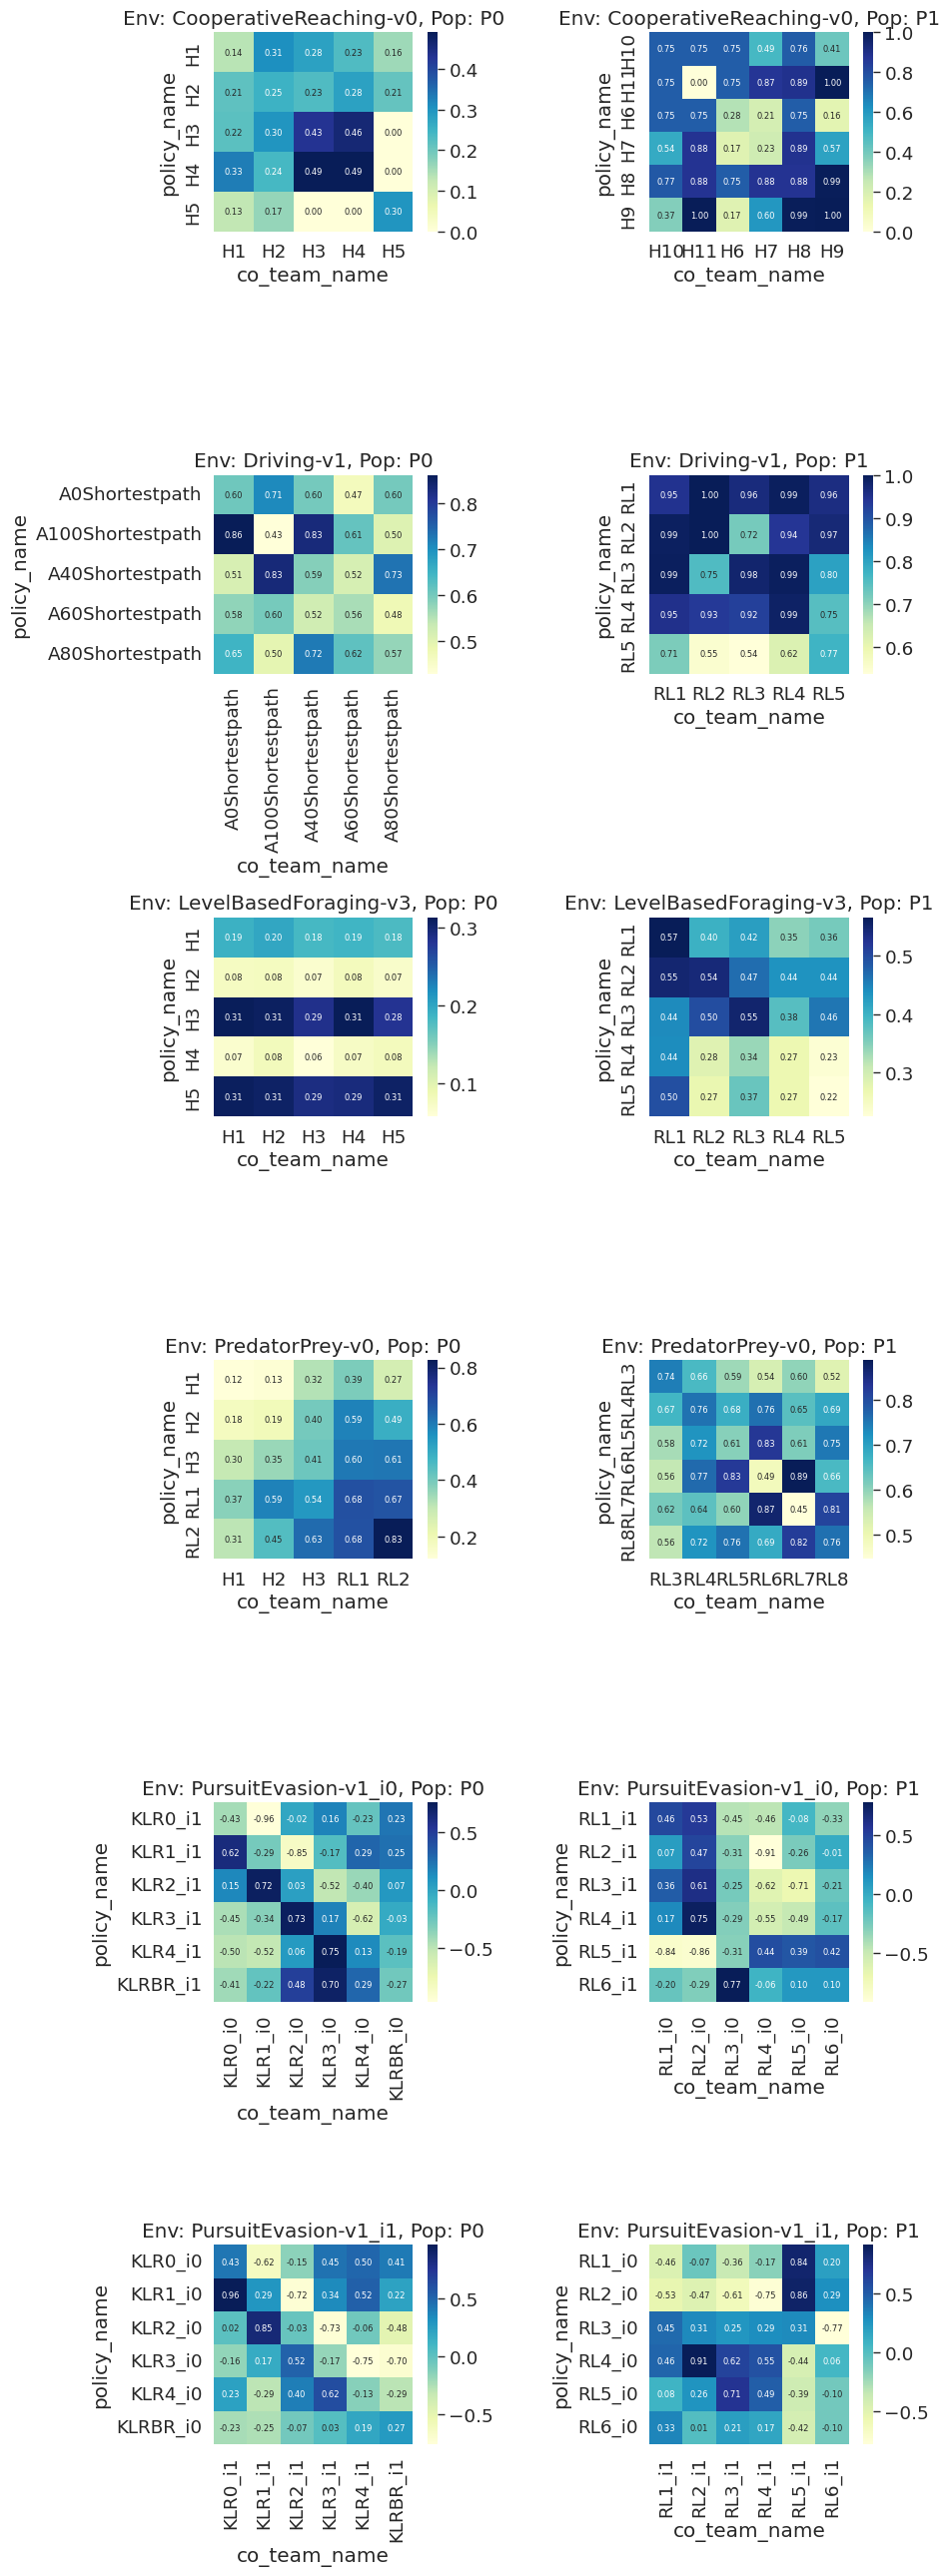

In [4]:
fig, axes = plt.subplots(nrows=NUM_ENVS, ncols=2, figsize=(10, (NUM_ENVS * 4) + 2))

for row, (env_id, env_data) in enumerate(ENV_DATA.items()):
    agent_id = 0 if env_data["agent_id"] is None else env_data["agent_id"]
    print(env_id, agent_id)
    for col, pop_id in enumerate(["P0", "P1"]):
        env_df = div_results[
            (div_results["env_agent_id"] == env_id) &
            (div_results["agent_id"] == agent_id) &
            (div_results["policy_pop_id"] == pop_id) &
            (div_results["co_team_pop_id"] == pop_id)
        ]
        pw_returns = env_df.pivot(index="policy_name", columns="co_team_name", values="episode_reward_mean")
        sns.heatmap(
            data=pw_returns,
            ax=axes[row, col],
            annot=True,
            cmap="YlGnBu",
            fmt=".2f",
            square=True,
            annot_kws={"fontsize": 6}
        )
        axes[row, col].set_title(f"Env: {env_id}, Pop: {pop_id}")

fig.tight_layout()


# Extract Pairwise Returns

In [24]:
env_pw_returns = {}
for (env_id, env_data) in ENV_DATA.items():
    agent_id = 0 if env_data["agent_id"] is None else env_data["agent_id"]
    print(env_id, agent_id)
    env_pw_returns[env_id] = {}
    for pop_id in ["P0", "P1"]:
        env_df = div_results[
            (div_results["env_agent_id"] == env_id) &
            (div_results["agent_id"] == agent_id) &
            (div_results["policy_pop_id"] == pop_id) &
            (div_results["co_team_pop_id"] == pop_id)
        ]

        policy_names = env_df["policy_name"].unique().tolist()
        policy_names.sort()

        co_team_names = env_df["co_team_name"].unique().tolist()
        co_team_names.sort()

        pw_returns = {n: {} for n in policy_names}
        for policy_name in policy_names:
            for co_team_name in co_team_names:
                policy_df = env_df[
                    (env_df["policy_name"] == policy_name) &
                    (env_df["co_team_name"] == co_team_name)
                ]
                pw_returns[policy_name][co_team_name] = float(
                    policy_df["episode_reward_mean"].mean()
                )

        env_pw_returns[env_id][pop_id] = pw_returns
        

CooperativeReaching-v0 0
Driving-v1 0
LevelBasedForaging-v3 0
PredatorPrey-v0 0
PursuitEvasion-v1_i0 1
PursuitEvasion-v1_i1 0


# Compute Meta-Policy

In [28]:
env_meta_policies = {}
for (env_id, env_data) in ENV_DATA.items():
    agent_id = 0 if env_data["agent_id"] is None else env_data["agent_id"]
    print(env_id, agent_id)
    env_meta_policies[env_id] = {}
    for pop_id in ["P0", "P1"]:
        env_meta_policies[env_id][pop_id] = {
            "uniform": POTMMCPMetaPolicy.get_uniform_meta_policy(
                env_pw_returns[env_id][pop_id]
            ),
            "softmax": POTMMCPMetaPolicy.get_softmax_meta_policy(
                env_pw_returns[env_id][pop_id],
                SOFTMAX_TEMP
            ),
            "greedy": POTMMCPMetaPolicy.get_greedy_meta_policy(
                env_pw_returns[env_id][pop_id]
            )
        }

    print("Writing meta policy to file: ", env_data["meta_policy_file"])
    with open(env_data["meta_policy_file"], "w") as f:
        yaml.dump(env_meta_policies[env_id], f)


CooperativeReaching-v0 0
Writing meta policy to file:  /home/jonathon/code/posggym-dev/posggym-baselines/baseline_exps/env_data/CooperativeReaching-v0/meta_policy.yaml
Driving-v1 0
Writing meta policy to file:  /home/jonathon/code/posggym-dev/posggym-baselines/baseline_exps/env_data/Driving-v1/meta_policy.yaml
LevelBasedForaging-v3 0
Writing meta policy to file:  /home/jonathon/code/posggym-dev/posggym-baselines/baseline_exps/env_data/LevelBasedForaging-v3/meta_policy.yaml
PredatorPrey-v0 0
Writing meta policy to file:  /home/jonathon/code/posggym-dev/posggym-baselines/baseline_exps/env_data/PredatorPrey-v0/meta_policy.yaml
PursuitEvasion-v1_i0 1
Writing meta policy to file:  /home/jonathon/code/posggym-dev/posggym-baselines/baseline_exps/env_data/PursuitEvasion-v1_i0/meta_policy.yaml
PursuitEvasion-v1_i1 0
Writing meta policy to file:  /home/jonathon/code/posggym-dev/posggym-baselines/baseline_exps/env_data/PursuitEvasion-v1_i1/meta_policy.yaml
